`Timeline // Watermark Detection`

    Phase 0
    - Research (11-12 Oct) // Done
    
    Phase 1 (11-13 Oct)
    - Manual Label (create bbox for Object Detection) // Done
    - Plot sample image // Done
    - Analyze and Prepocess Data // Data Preprocessing + Data Augmentation // Done
        - Handling imbalance - Data Augmentation on minority labels // Done -> class weight
    - Training Model // Open
    - Evaluate Result // Open

    Phase 2 (13-14 Oct) // Open
    - Analyze and Prepocess Data // Data Preprocessing + Data Augmentation + Manual Label (create bbox for Object Detection)
        - Try 2 type of labeling
            - Seperate into 3 label (Do multiclass prediction) - no watermark, non r123 watermark, r123 watermark
            - Multilabel Prediction - the result
                - bbox - to detect watermark
                - predict - no watermark, non r123 watermark, r123 watermark
        - Handling imbalance - Data Augmentation on minority labels
    - Training Model
    - Evaluate Result

    Phase 3 (14 Oct) // Open
    - Create framework to predict unseen 
    - Deployment (FastAPI, Kubernetes, Docker, Streamlit)
    - CI/CD (Airflow)

    Phase 4 (14-15 Oct) // Open
    - Documentation
    - Notes
        - improve data quality
            - Watermark 123 jgn di timpa 
            - HD, so many blurry data
        - import data size

# 0 - Labeling

In [2]:
!pip install --upgrade pyqt5 lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 915.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 1.0 MB/s eta 0:00:0000:010m00:02


In [7]:
LABELING__PATH = os.path.join('data', 'labelimg')

In [8]:
if not os.path.exists(LABELING__PATH):
    !mkdir {LABELING__PATH}
    !git clone https://github.com/tzutalin/labelImg {LABELING__PATH}

mkdir: data: No such file or directory
Cloning into 'data/labelimg'...
remote: Enumerating objects: 2097, done.
Receiving objects: 100% (2097/2097), 237.15 MiB | 1.34 MiB/s, done.
remote: Total 2097 (delta 0), reused 0 (delta 0), pack-reused 2097 (from 1)
Resolving deltas: 100% (1222/1222), done.


In [9]:
if os.name == 'posix':
    !cd {LABELING__PATH} && make qt5py3
if os.name =='nt':
    !cd {LABELING__PATH} && pyrcc5 -o libs/resources.py resources.qrc

pyrcc5 -o libs/resources.py resources.qrc


In [11]:
!cd {LABELING__PATH} && python labelImg.py

Cancel creation.
Image:/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/data/all_data/1LLkEGO9KpxjpKDz.jpg -> Annotation:/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/data/new_label_imgs/1LLkEGO9KpxjpKDz.xml
Image:/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/data/all_data/1Zs5VFg3hoZD7aSv.jpg -> Annotation:/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/data/new_label_imgs/1Zs5VFg3hoZD7aSv.xml
Image:/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/data/all_data/3dFnxTjlIbT9tQva.jpg -> Annotation:/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/data/new_label_imgs/3dFnxTjlIbT9tQva.xml
Cancel creation.
Image:/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/data/all_data/3oatBcyDa94sDBMC.jpg -> Annotation:/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/data/new_label_imgs/3oatBcyDa94sDBMC.xml
Cancel creation.
Image:/Users/driandy/Desktop/

# 1 - Data Preprocessing

## 1.1 - Setup and Imoprts

In [104]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# import torch
# import torch.cuda as cuda
import xml.etree.ElementTree as ET
import random

# Paths
original_img_dir = './data/all_data/'
annotated_img_dir = './data/new_label_imgs/'
non_watermark_dir = './data/non_watermark/'
r123_watermark_dir = './data/r123_watermark/'


def check_gpu():
    print("PyTorch version:", torch.__version__)
    
    if torch.cuda.is_available():
        print("CUDA is available!")
        print("CUDA version:", torch.version.cuda)
        
        # Get the current device
        current_device = torch.cuda.current_device()
        print("Current CUDA device:", current_device)
        
        # Get the name of the current device
        print("Device name:", torch.cuda.get_device_name(current_device))
        
        # Memory information
        print("Total memory:", torch.cuda.get_device_properties(current_device).total_memory / 1e9, "GB")
        print("Allocated memory:", torch.cuda.memory_allocated(current_device) / 1e9, "GB")
        print("Cached memory:", torch.cuda.memory_reserved(current_device) / 1e9, "GB")
        
        # Compute capability
        print("Compute capability:", torch.cuda.get_device_capability(current_device))
    else:
        print("CUDA is not available. You are using CPU.")
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    filename = root.find('filename').text
    
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    
    objects = root.findall('object')
    bboxes = []
    for obj in objects:
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        bboxes.append((name, (xmin, ymin, xmax, ymax)))
    
    return filename, bboxes, (width, height)
def visualize_image_with_bboxes(original_img_path, xml_path):
    filename, bboxes, (width, height) = parse_xml(xml_path)
    
    # Load the image
    img = Image.open(original_img_path)
    
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(10, 10))
    
    # Display the image
    ax.imshow(img)
    
    # Color map for different types of watermarks
    color_map = {'r123': 'r', 'non_r123': 'b'}
    
    # Create Rectangle patches for each bbox
    for name, (xmin, ymin, xmax, ymax) in bboxes:
        color = color_map.get(name, 'g')  # Default to green if name not in color_map
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Add label
        ax.text(xmin, ymin - 5, name, color=color, fontsize=10, 
                bbox=dict(facecolor='white', edgecolor=color, alpha=0.8))
    
    plt.title(f"{filename} - {len(bboxes)} watermark(s)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
def plot_sample_images(directory, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    for i in range(num_samples):
        img_name = np.random.choice(os.listdir(directory))
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Size: {img.shape[1]}x{img.shape[0]}")
    plt.tight_layout()
    # return fig
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
def get_train_transform():
    return A.Compose([
        A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0)),
        A.Flip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.GaussNoise(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
def get_valid_transform():
    return A.Compose([
        A.Resize(height=224, width=224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
def visualize_augmentation(image, bboxes, augmented_image, augmented_bboxes):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image
    ax1.imshow(image)
    ax1.set_title('Original Image')
    for bbox in bboxes:
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], 
                             linewidth=1, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)
    
    # Augmented image
    ax2.imshow(augmented_image.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
    ax2.set_title('Augmented Image')
    for bbox in augmented_bboxes:
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], 
                             linewidth=1, edgecolor='r', facecolor='none')
        ax2.add_patch(rect)
    
    plt.show()


# Paths
data_dir = '/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/data'
original_img_dir = '/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/data/all_data/'
annotated_img_dir = '/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/data/new_label_imgs/'

# Example usage
xml_filename = random.choice(os.listdir(annotated_img_dir))   # Replace with your chosen XML filename
xml_path = os.path.join(annotated_img_dir, xml_filename)

check_gpu()

PyTorch version: 2.4.1
CUDA is not available. You are using CPU.


## 1.2 - Data Visualization

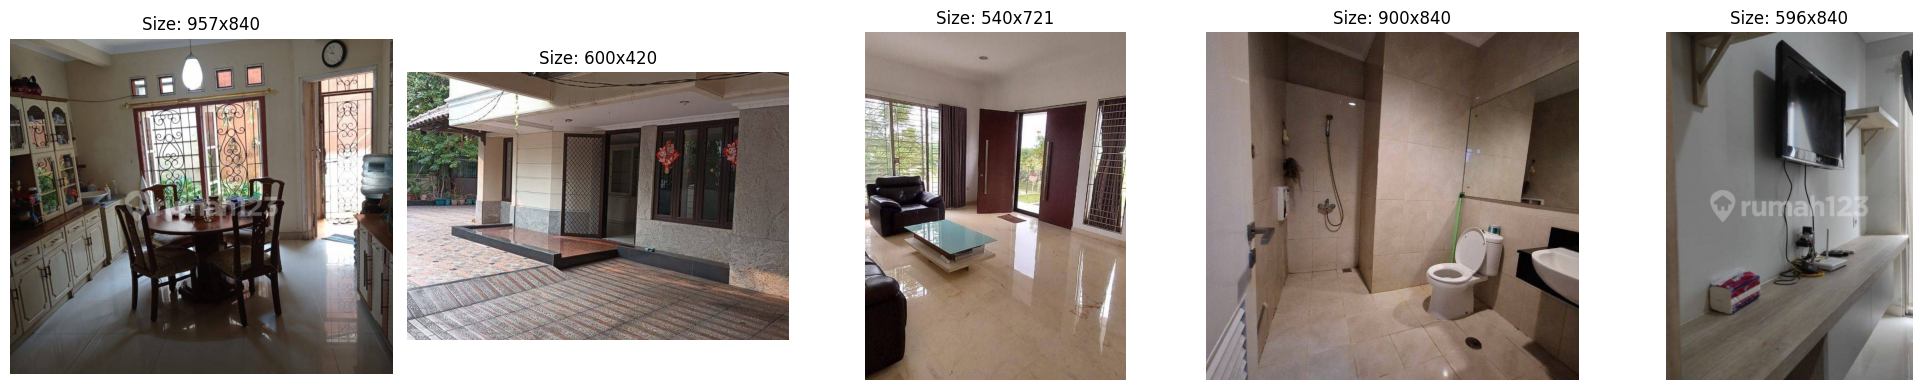

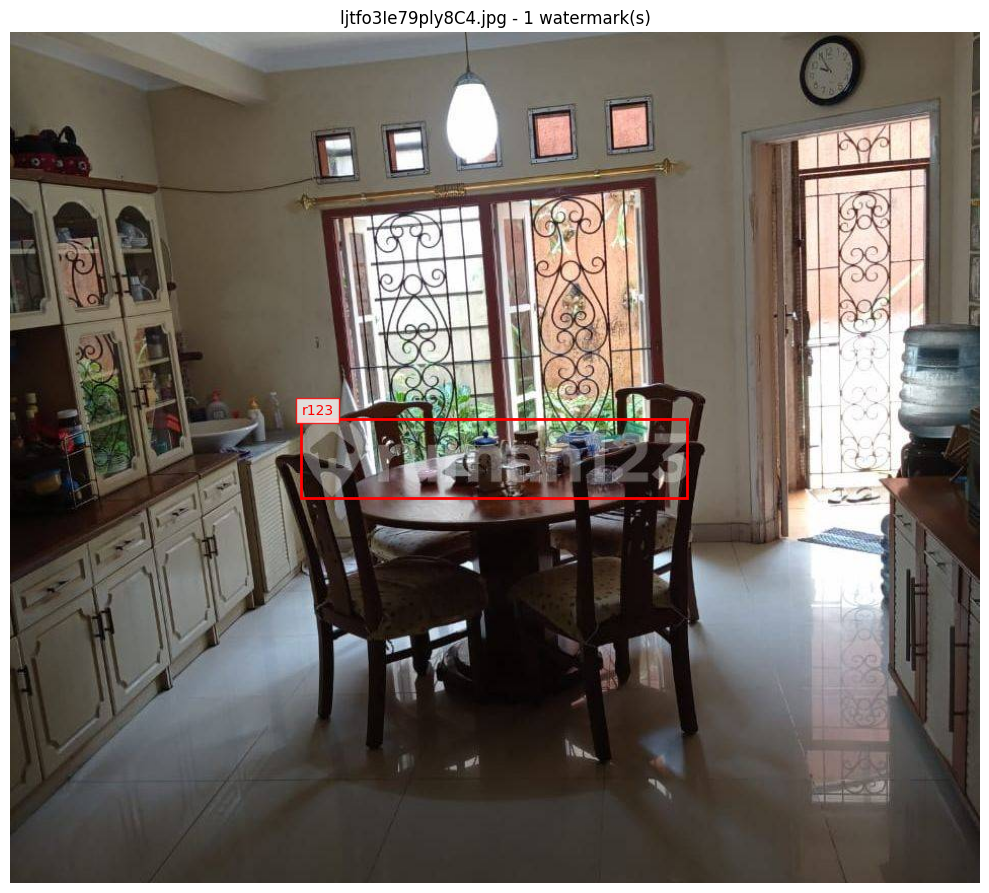

In [25]:
plot_sample_images(original_img_dir)

if os.path.exists(xml_path):
    filename, _, _ = parse_xml(xml_path)
    original_img_path = os.path.join(original_img_dir, filename)
    
    if os.path.exists(original_img_path):
        visualize_image_with_bboxes(original_img_path, xml_path)
    else:
        print(f"Original image not found: {original_img_path}")
else:
    print(f"XML file not found: {xml_path}")
    print("This image might not have a watermark.")

Classification Task - Non-R123 Watermark: 99, R123 Watermark: 42


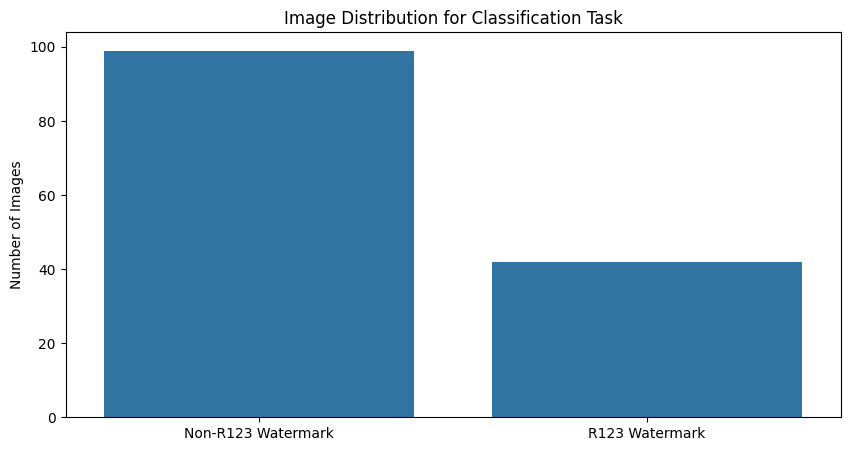

In [30]:
# Image Classification
non_watermark_count = count_images(data_dir + '/non_watermark/')
r123_watermark_count = count_images(data_dir + '/r123-watermark/')

plt.figure(figsize=(10, 5))
sns.barplot(x=['Non-R123 Watermark', 'R123 Watermark'], y=[non_watermark_count, r123_watermark_count])
plt.title('Image Distribution for Classification Task')
plt.ylabel('Number of Images')

print(f"Classification Task - Non-R123 Watermark: {non_watermark_count}, R123 Watermark: {r123_watermark_count}")

## 1.3 - Data Augmentation

In [106]:
__SAMPLE

'uWDhVO8LtxyTPG2p.xml'

In [108]:
# __SAMPLE = random.choice(os.listdir(data_dir + '/new_label_imgs/'))
__SAMPLE = 'HyXe39tz4Bgdgxdn'

image = Image.open(os.path.join(data_dir + '/r123-watermark/',  __SAMPLE.split('.')[0]+ '.jpg')).convert('RGB')
bboxes = [list(parse_xml(annotated_img_dir + __SAMPLE)[1][0][1])]  # Example bounding box, replace with actual data

transform = get_train_transform()
transformed = transform(image=np.array(image), bboxes=bboxes, labels=['watermark']*len(bboxes))

augmented_image = transformed['image']
augmented_bboxes = transformed['bboxes']

visualize_augmentation(np.array(image), bboxes, augmented_image, augmented_bboxes)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/data/r123-watermark/HyXe39tz4Bgdgxdn.jpg'

# 2 - Data Splitting and Dataset Creation

## 2.1 - Data Splitting

In [98]:
class WatermarkDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=np.array(image))['image']

        return image, label

class WatermarkDetectionDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        
        xml_file = os.path.join(annotated_img_dir, os.path.splitext(os.path.basename(img_path))[0] + '.xml')
        _, boxes, labels = parse_xml(xml_file)
        
        if self.transform:
            transformed = self.transform(image=np.array(img), bboxes=boxes, labels=labels)
            img = transformed['image']
            boxes = transformed['bboxes']
        
        target = {}
        target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels, dtype=torch.int64)
        
        return img, target

def calculate_class_weights(labels):
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (len(class_counts) * class_counts)
    return torch.FloatTensor(class_weights)

def split_data(image_paths, labels, test_size=0.2, random_state=42):
    return train_test_split(image_paths, labels, test_size=test_size, random_state=random_state, stratify=labels)

def include_list(_arr, include):
    temp = []
    for i in _arr:
        for _include in include:
            if i.endswith(_include):
                temp.append(i)
            else:
                continue
    return temp


In [99]:
# For image classification
all_image_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir + '/non_watermark/')] + \
                  [os.path.join(data_dir, f) for f in os.listdir(data_dir + '/r123-watermark/')]
all_labels = [0] * len(os.listdir(data_dir + '/non_watermark/')) + [1] * len(os.listdir(data_dir + '/r123-watermark/'))

train_paths, test_paths, train_labels, test_labels = split_data(all_image_paths, all_labels)

print(f"Classification - Training samples: {len(train_paths)}, Testing samples: {len(test_paths)}")

Classification - Training samples: 113, Testing samples: 29


In [100]:
# For object detection
OD__DATA = [i.split('.')[0] for i in include_list(os.listdir(data_dir + '/new_label_imgs'), ['.xml'])]
watermark_images = [os.path.join(data_dir + '/all_data/', f + '.jpg') for f in OD__DATA]
train_od_paths, test_od_paths = train_test_split(watermark_images, test_size=0.2, random_state=42)

print(f"Object Detection - Training samples: {len(train_od_paths)}, Testing samples: {len(test_od_paths)}")

Object Detection - Training samples: 48, Testing samples: 12


## 2.2 - Dataset Creation

In [101]:
class_weights = calculate_class_weights(train_labels)
print("Class weights:", class_weights)

# Create weighted sampler for classification training data
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Create datasets and dataloaders for classification
train_dataset = WatermarkDataset(train_paths, train_labels, transform=get_train_transform())
test_dataset = WatermarkDataset(test_paths, test_labels, transform=get_valid_transform())

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create datasets and dataloaders for object detection
train_od_dataset = WatermarkDetectionDataset(train_od_paths, transform=get_train_transform())
test_od_dataset = WatermarkDetectionDataset(test_od_paths, transform=get_valid_transform())

train_od_loader = DataLoader(train_od_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_od_loader = DataLoader(test_od_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

Class weights: tensor([0.7152, 1.6618])


/var/folders/dr/ws9cv98n2h108c3cntr42tb40000gn/T/ipykernel_3156/3155439623.py:4: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),


# 3 - Model Training and Evaluation

In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Classification Model
class WatermarkClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(WatermarkClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

classification_model = WatermarkClassifier().to(device)
classification_criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
classification_optimizer = torch.optim.Adam(classification_model.parameters(), lr=0.001)

# Object Detection Model
def get_object_detection_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

detection_model = get_object_detection_model(num_classes=2).to(device)  # Background and watermark
detection_optimizer = torch.optim.SGD(detection_model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train_classification_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = train_correct / train_total
        train_accuracies.append(train_accuracy)

        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_accuracy = test_correct / test_total
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return model, train_accuracies, test_accuracies

def train_detection_model(model, data_loader, optimizer, num_epochs=10):
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()
        
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")

    return model

# Train Classification Model
print("Training Classification Model...")
classification_model, train_accuracies, test_accuracies = train_classification_model(
    classification_model, train_loader, test_loader, classification_criterion, classification_optimizer
)

# Plot training performance for classification
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Model Performance')
plt.legend()
plt.show()

# Train Object Detection Model
print("Training Object Detection Model...")
detection_model = train_detection_model(detection_model, train_od_loader, detection_optimizer)

print("Model training completed.")

# HIDE

In [48]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Adjust the number of output classes (2 classes: watermark and non_watermark)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Loss function that includes class weights
def custom_loss_fn(targets, outputs, class_weights):
    loss = torch.nn.functional.cross_entropy(outputs['classification'], targets['labels'], weight=class_weights)
    return loss

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)

/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

KeyboardInterrupt: 